# XGBoost

* 트리 기반의 앙상블 기법
* 분류에 있어서 다른 알고리즘보다 좋은 예측 성능을 보여줌
* XGBoost는 GBM 기반이지만, GBM의 단점인 느린 수행 시간과 과적합 규제 부재 등의 문제를 해결
* 병렬 CPU 환경에서 빠르게 학습 가능

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import seaborn as sns
import graphviz
import warnings

In [2]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.datasets import load_boston, load_diabetes
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance, plot_tree


from sklearn.pipeline import make_pipeline, Pipeline # 개체도가져온것
from sklearn.preprocessing import StandardScaler, MinMaxScaler



## 파이썬 기반 XGBoost

In [3]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=123)

# D
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label= y_test)

In [4]:
params = {'max_depth' : 3,
          'eta': 0.1,
          'objective' : 'binary:logistic',
          'eval_metric' : 'logloss',
          'early_stoppings' : 100
         }
num_rounds=400

In [5]:
# train 데이터는 train으로 evaluation(test)는 eval로 명기

evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                      early_stopping_rounds=100, evals=evals)

[20:48:41] WARNING: /private/var/folders/c_/xfclsffs46x_pr2y70z2qfsm0000gn/T/pip-install-2ryh9kq2/xgboost_30fd9ab60f844430adff9dae2bdab19a/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60944	eval-logloss:0.61010
[1]	train-logloss:0.54047	eval-logloss:0.54074
[2]	train-logloss:0.48211	eval-logloss:0.48490
[3]	train-logloss:0.43365	eval-logloss:0.43922
[4]	train-logloss:0.39072	eval-logloss:0.39791
[5]	train-logloss:0.35372	eval-logloss:0.36211
[6]	train-logloss:0.32222	eval-logloss:0.32996
[7]	train-logloss:0.29292	eval-logloss:0.30179
[8]	train-logloss:0.26731	eval-logloss:0.27801
[9]	train-logloss:0.24409	eval-logloss:0.25775
[10]	train-logloss:0.22517	eval-logl

In [6]:
predicts = xgb_model.predict(dtest)
print(np.round(predicts[:10],3))

[1.    0.999 0.001 0.995 0.001 0.989 0.995 0.998 0.966 0.795]


In [7]:
preds = [1 if x> 0.5 else 0 for x in predicts]
print(preds[:10])

[1, 1, 0, 1, 0, 1, 1, 1, 1, 1]


In [8]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [9]:
get_clf_eval(y_test,preds)

오차행렬:
 [[39  2]
 [ 1 72]]

정확도: 0.9737
정밀도: 0.9730
재현율: 0.9863
F1: 0.9796
AUC: 0.9688


In [10]:
print("정확도 : {}".format(accuracy_score(y_test, preds)))
print("정밀도 : {}".format(precision_score(y_test, preds)))
print("재현율 : {}".format(recall_score(y_test, preds)))


정확도 : 0.9736842105263158
정밀도 : 0.972972972972973
재현율 : 0.9863013698630136


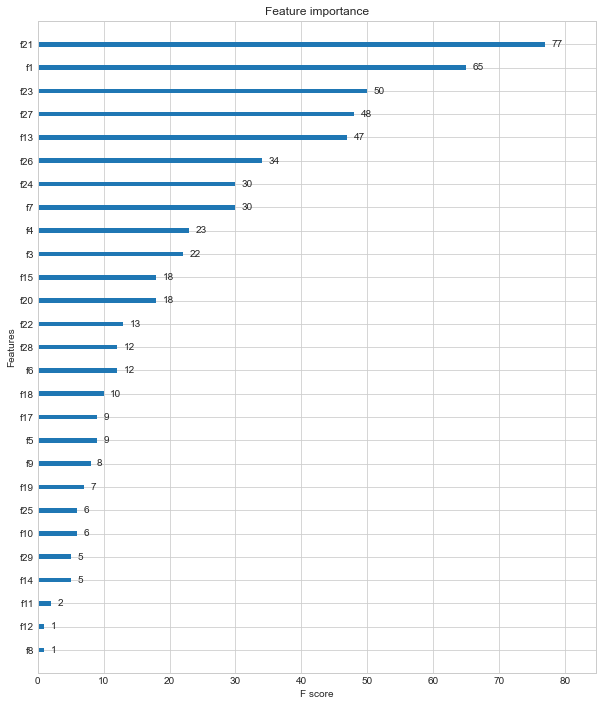

In [11]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax);

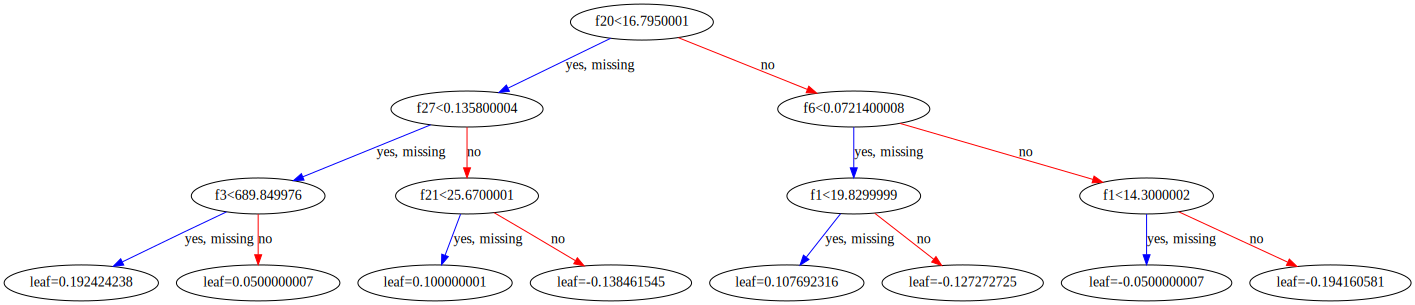

In [12]:
graph = xgb.to_graphviz(xgb_model)
graph

## XGBClassifier

### 붓꽃 데이터

In [13]:
# sklearn내장되어있는 xgbclassfier 사용
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=123)

In [14]:
xgbc = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3, 
                     use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]


In [15]:
cross_val = cross_validate(
    estimator=xgbc,
    X=iris.data, y=iris.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.050069999694824216 (+/- 0.0019514956723705656)
avg score time: 0.0009050846099853515 (+/- 3.6148030831349355e-05)
avg test score: 0.96 (+/- 0.024944382578492935)


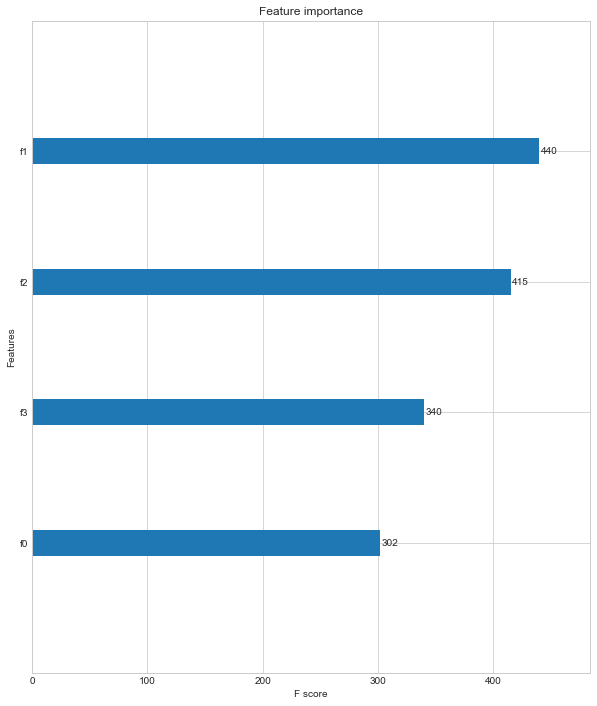

In [16]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax);

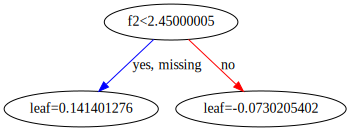

In [17]:
graph = xgb.to_graphviz(xgbc)
graph

### 와인 데이터

In [18]:
# sklearn내장되어있는 xgbclassfier 사용
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.2, random_state=123)

In [19]:
xgbc = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3, 
                     use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]


In [20]:
cross_val = cross_validate(
    estimator=xgbc,
    X=wine.data, y=wine.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.07638111114501953 (+/- 0.012461422423419338)
avg score time: 0.000910186767578125 (+/- 5.6024125121294365e-05)
avg test score: 0.9609523809523809 (+/- 0.028267341226138717)


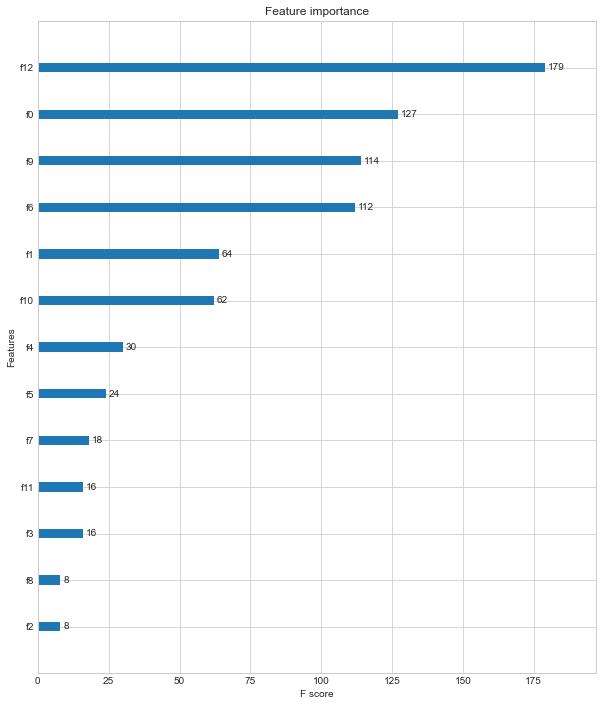

In [21]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax);

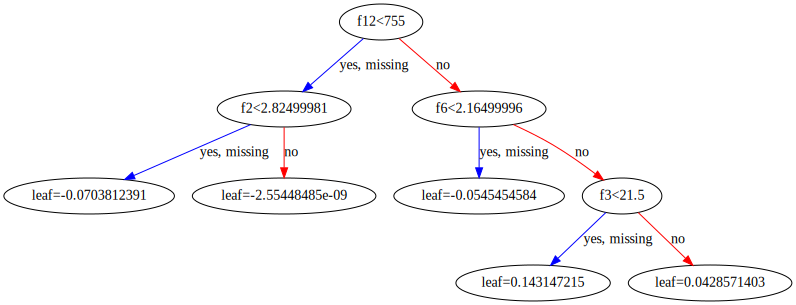

In [22]:
graph = xgb.to_graphviz(xgbc)
graph

### 유방암 데이터

In [23]:
# sklearn내장되어있는 xgbclassfier 사용
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size=0.2, random_state=123)

In [24]:
xgbc = XGBClassifier(n_estimators = 400, learning_rate=0.1, max_depth=3, 
                     use_label_encoder=False, eval_metric='logloss')
xgbc.fit(X_train, y_train)
preds = xgbc.predict(X_test)
preds_proba = xgbc.predict_proba(X_test)[:, 1]


In [25]:
cross_val = cross_validate(
    estimator=xgbc,
    X=cancer.data, y=cancer.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.1506603717803955 (+/- 0.004199378915477008)
avg score time: 0.0009448528289794922 (+/- 3.352711200340265e-05)
avg test score: 0.9736376339077782 (+/- 0.009609619188189153)


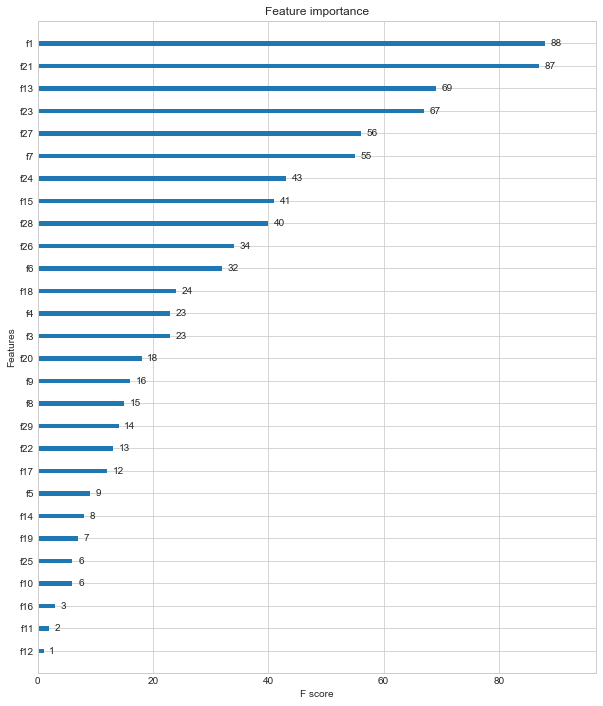

In [26]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbc, ax=ax);

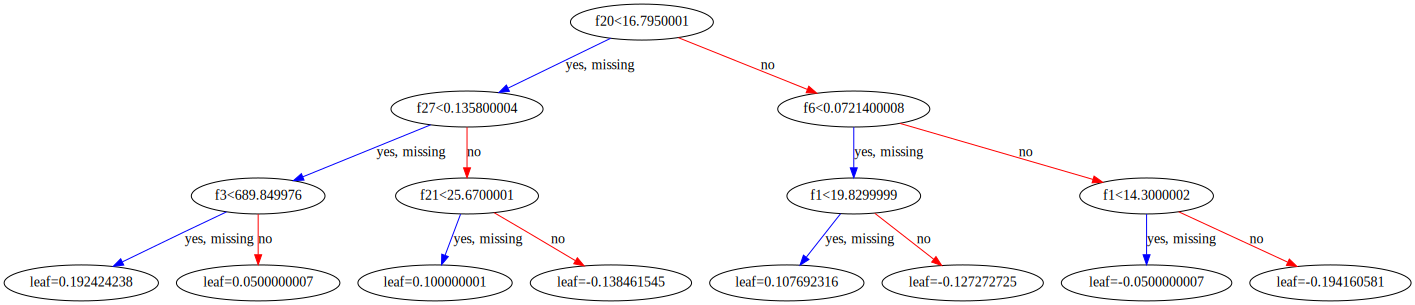

In [27]:
graph = xgb.to_graphviz(xgbc)
graph

## XGBRegressor

### 보스턴 데이터

In [28]:
# sklearn내장되어있는 xgbclassfier 사용
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.2, random_state=123)

/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [29]:
xgbr = XGBRegressor(n_estimators = 400, learning_rate=0.1, max_depth=3, objective='reg:squarederror')
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)



In [30]:
cross_val = cross_validate(
    estimator=xgbr,
    X=boston.data, y=boston.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.11259870529174805 (+/- 0.0019628149043267812)
avg score time: 0.0009846687316894531 (+/- 5.2683924786130185e-05)
avg test score: 0.6884390736705599 (+/- 0.1649974770303876)


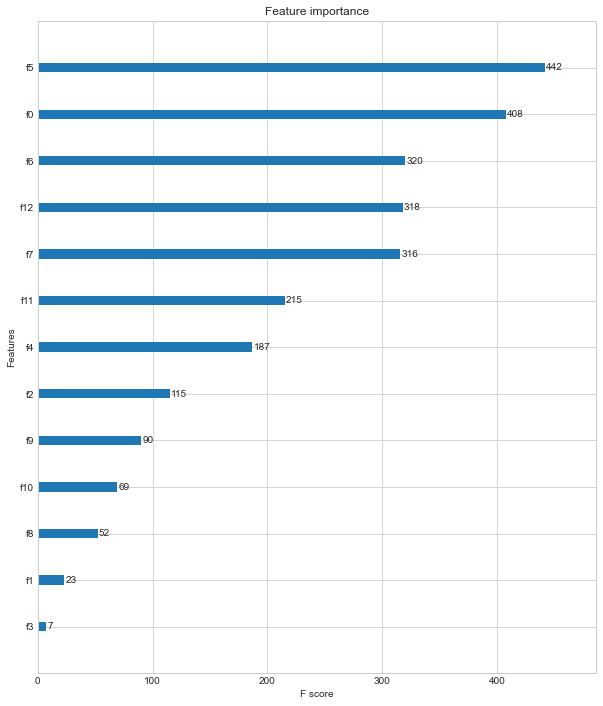

In [31]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbr, ax=ax);

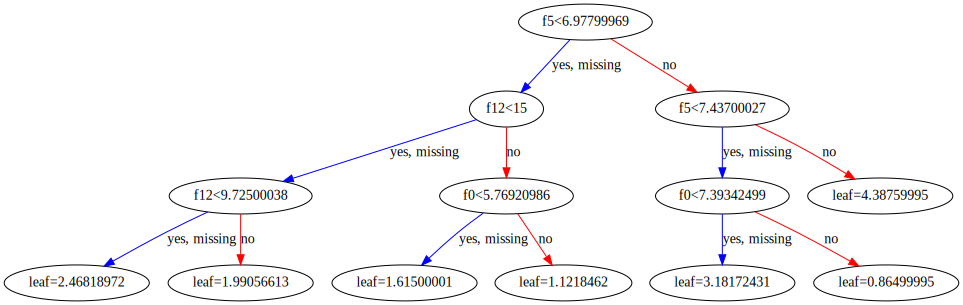

In [32]:
graph = xgb.to_graphviz(xgbr)
graph

### 당뇨병 데이터

In [33]:
# sklearn내장되어있는 xgbclassfier 사용
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.2, random_state=123)

In [34]:
xgbr = XGBRegressor(n_estimators = 400, learning_rate=0.1, max_depth=3, objective='reg:squarederror')
xgbr.fit(X_train, y_train)
preds = xgbr.predict(X_test)



In [35]:
cross_val = cross_validate(
    estimator=xgbr,
    X=diabetes.data, y=diabetes.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.08873276710510254 (+/- 0.0014391988055441117)
avg score time: 0.0010205745697021485 (+/- 0.00010162826224951665)
avg test score: 0.30005291115066424 (+/- 0.07589309667544569)


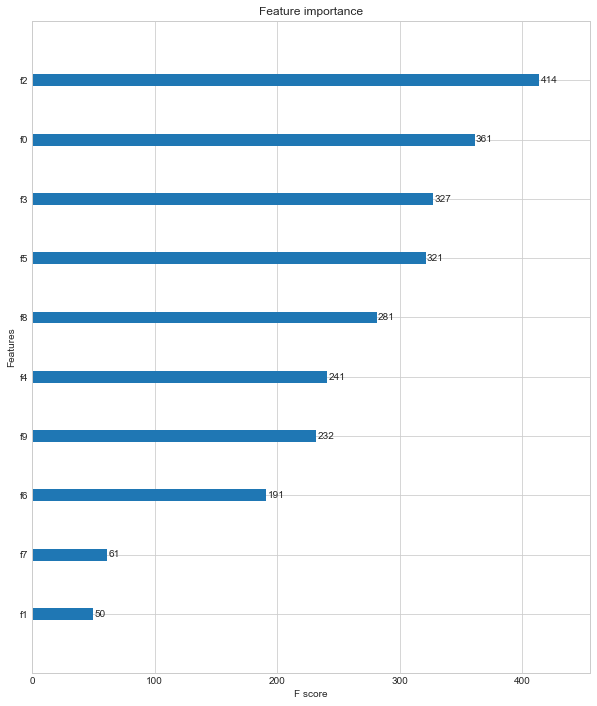

In [36]:
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgbr, ax=ax);

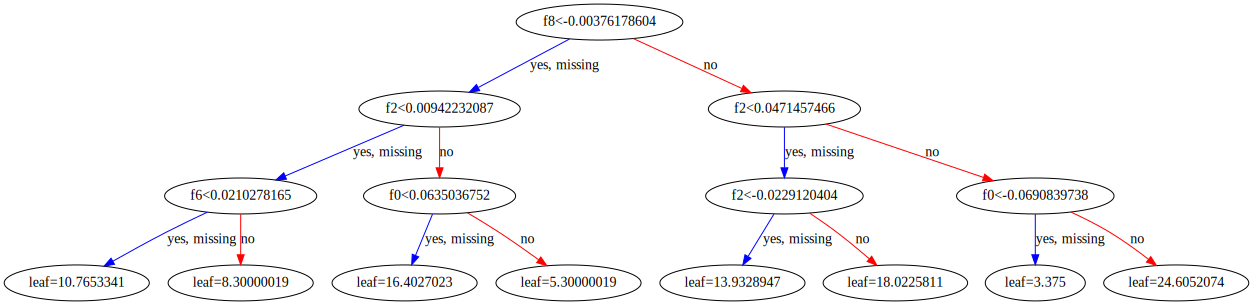

In [37]:
graph = xgb.to_graphviz(xgbr)
graph

# LightGBM

* 빠른 학습과 예측 시간
* 더 적은 메모리 사용
* 범주형 특징의 자동 변환과 최적 분할

In [38]:
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
# xgboost와 동일하므로 충돌주의

## LGBMClassifier

### 붓꽃 데이터

In [39]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size=0.2, random_state=123)

In [40]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals,
          verbose=True)

preds = lgbmc.predict(X_test)

[1]	valid_0's multi_logloss: 0.95847
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.832184
[3]	valid_0's multi_logloss: 0.731164
[4]	valid_0's multi_logloss: 0.641056
[5]	valid_0's multi_logloss: 0.571726
[6]	valid_0's multi_logloss: 0.507286
[7]	valid_0's multi_logloss: 0.454933
[8]	valid_0's multi_logloss: 0.410205
[9]	valid_0's multi_logloss: 0.372194
[10]	valid_0's multi_logloss: 0.333919
[11]	valid_0's multi_logloss: 0.310212
[12]	valid_0's multi_logloss: 0.282326
[13]	valid_0's multi_logloss: 0.257165
[14]	valid_0's multi_logloss: 0.240836
[15]	valid_0's multi_logloss: 0.225383
[16]	valid_0's multi_logloss: 0.211583
[17]	valid_0's multi_logloss: 0.199289
[18]	valid_0's multi_logloss: 0.186269
[19]	valid_0's multi_logloss: 0.171556
[20]	valid_0's multi_logloss: 0.168245
[21]	valid_0's multi_logloss: 0.161065
[22]	valid_0's multi_logloss: 0.151371
[23]	valid_0's multi_logloss: 0.148081
[24]	valid_0's multi_logloss: 0.143843
[25]	valid_0

In [41]:
cross_val = cross_validate(
    estimator=lgbmc,
    X=iris.data, y=iris.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.1948498249053955 (+/- 0.04532642996789052)
avg score time: 0.0006052017211914063 (+/- 0.0001005880723580286)
avg test score: 0.9600000000000002 (+/- 0.04898979485566355)


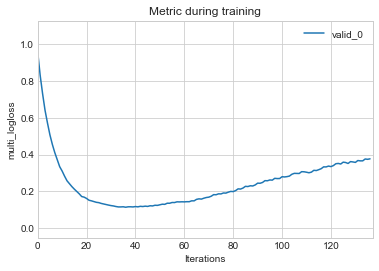

In [42]:
plot_metric(lgbmc);

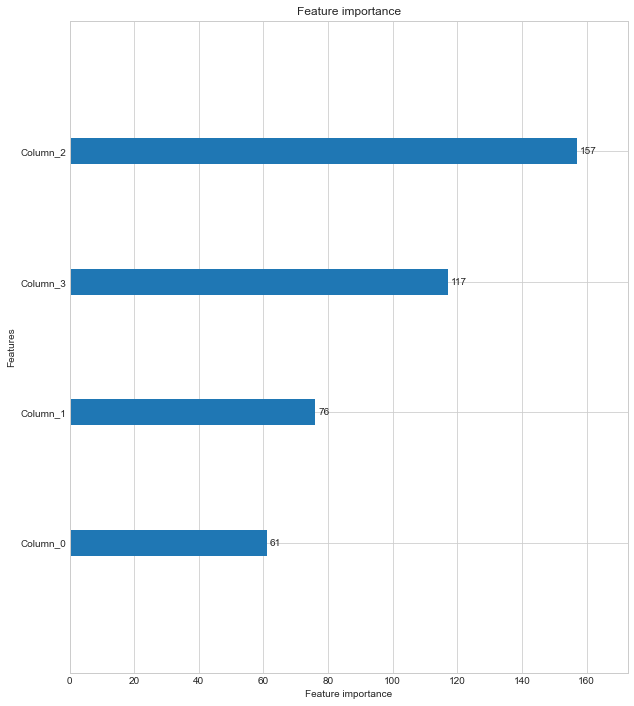

In [43]:
plot_importance(lgbmc, figsize=(10, 12));

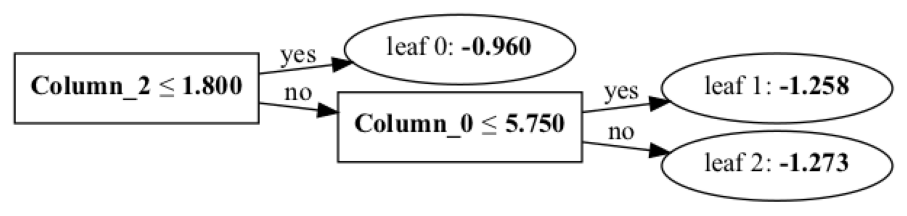

In [44]:
plot_tree(lgbmc, figsize=(16,10));

### 와인 데이터

In [45]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.2, random_state=123)

In [46]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals,
          verbose=True)

preds = lgbmc.predict(X_test)

[1]	valid_0's multi_logloss: 1.05985
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.941671
[3]	valid_0's multi_logloss: 0.838354
[4]	valid_0's multi_logloss: 0.761596
[5]	valid_0's multi_logloss: 0.677439
[6]	valid_0's multi_logloss: 0.607711
[7]	valid_0's multi_logloss: 0.556301
[8]	valid_0's multi_logloss: 0.51301
[9]	valid_0's multi_logloss: 0.460772
[10]	valid_0's multi_logloss: 0.418941
[11]	valid_0's multi_logloss: 0.386691
[12]	valid_0's multi_logloss: 0.354477
[13]	valid_0's multi_logloss: 0.325968
[14]	valid_0's multi_logloss: 0.302653
[15]	valid_0's multi_logloss: 0.279562
[16]	valid_0's multi_logloss: 0.258911
[17]	valid_0's multi_logloss: 0.239598
[18]	valid_0's multi_logloss: 0.220811
[19]	valid_0's multi_logloss: 0.203974
[20]	valid_0's multi_logloss: 0.188324
[21]	valid_0's multi_logloss: 0.175522
[22]	valid_0's multi_logloss: 0.162242
[23]	valid_0's multi_logloss: 0.151123
[24]	valid_0's multi_logloss: 0.140635
[25]	valid_0'

In [47]:
cross_val = cross_validate(
    estimator=lgbmc,
    X=wine.data, y=wine.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.15022702217102052 (+/- 0.07866831715532996)
avg score time: 0.0005669593811035156 (+/- 0.00012312975114910917)
avg test score: 0.9776190476190475 (+/- 0.01119469694127331)


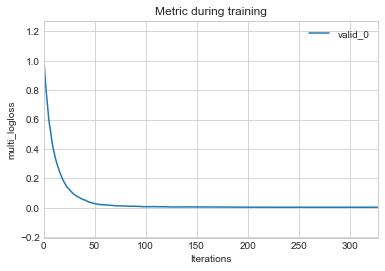

In [48]:
plot_metric(lgbmc);

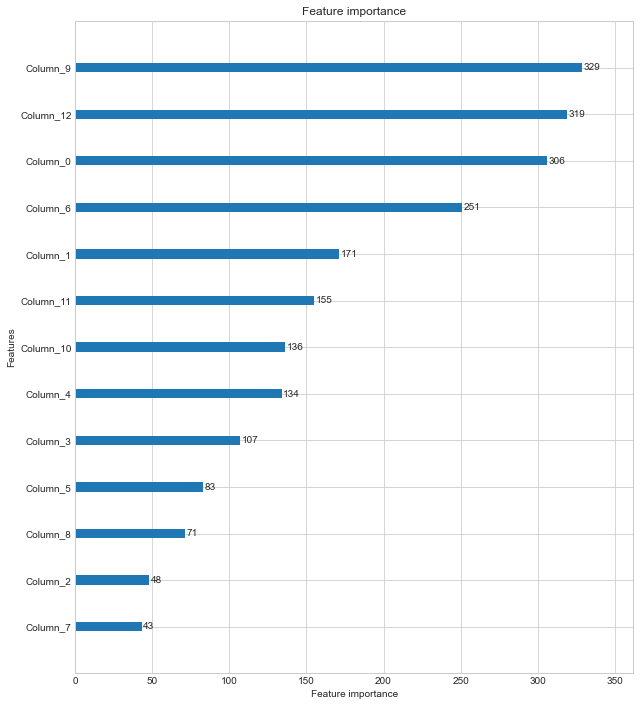

In [49]:
plot_importance(lgbmc, figsize=(10, 12));

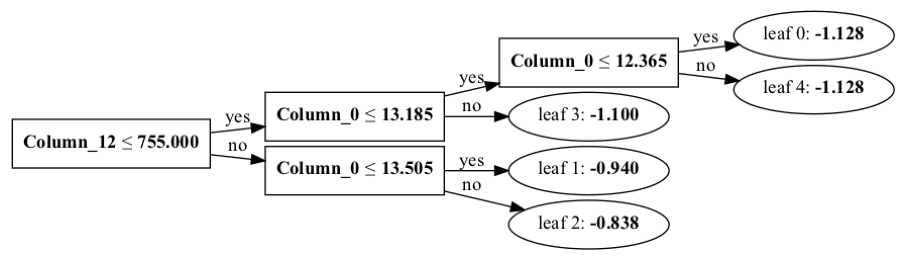

In [50]:
plot_tree(lgbmc, figsize=(16,10));

### 유방암 데이터

In [51]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, test_size=0.2, random_state=123)

In [52]:
lgbmc = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbmc.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals,
          verbose=True)

preds = lgbmc.predict(X_test)

[1]	valid_0's binary_logloss: 0.575665
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.513919
[3]	valid_0's binary_logloss: 0.463418
[4]	valid_0's binary_logloss: 0.420506
[5]	valid_0's binary_logloss: 0.383433
[6]	valid_0's binary_logloss: 0.351962
[7]	valid_0's binary_logloss: 0.325134
[8]	valid_0's binary_logloss: 0.301618
[9]	valid_0's binary_logloss: 0.276072
[10]	valid_0's binary_logloss: 0.259487
[11]	valid_0's binary_logloss: 0.244766
[12]	valid_0's binary_logloss: 0.224551
[13]	valid_0's binary_logloss: 0.211222
[14]	valid_0's binary_logloss: 0.197052
[15]	valid_0's binary_logloss: 0.187863
[16]	valid_0's binary_logloss: 0.180071
[17]	valid_0's binary_logloss: 0.172646
[18]	valid_0's binary_logloss: 0.162952
[19]	valid_0's binary_logloss: 0.154079
[20]	valid_0's binary_logloss: 0.146169
[21]	valid_0's binary_logloss: 0.140076
[22]	valid_0's binary_logloss: 0.132763
[23]	valid_0's binary_logloss: 0.127181
[24]	valid_0's binary_loglo

In [53]:
cross_val = cross_validate(
    estimator=lgbmc,
    X=cancer.data, y=cancer.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.2295234203338623 (+/- 0.05523916862280566)
avg score time: 0.0009897708892822265 (+/- 0.00023926240368617624)
avg test score: 0.9736531594472908 (+/- 0.015674460437800138)


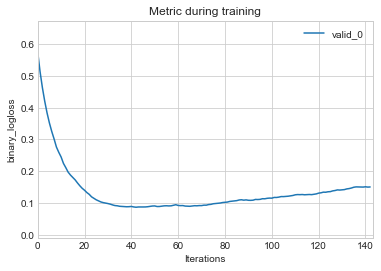

In [54]:
plot_metric(lgbmc);

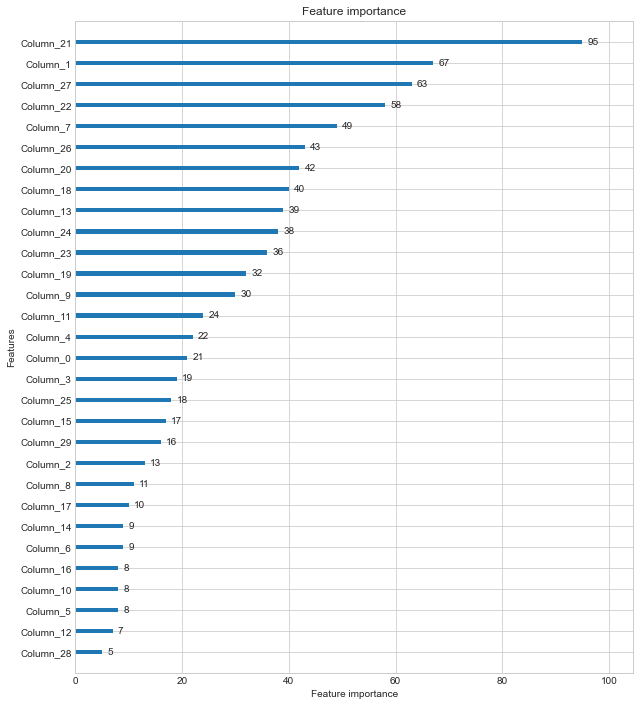

In [55]:
plot_importance(lgbmc, figsize=(10, 12));

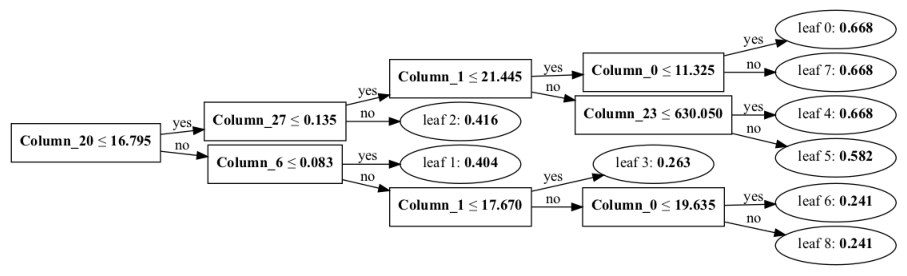

In [56]:
plot_tree(lgbmc, figsize=(16,10));

## LGBMRegressor

### 보스턴 데이터

In [57]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, test_size=0.2, random_state=123)

/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets incl

In [58]:
lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals,
          verbose=True)

preds = lgbmr.predict(X_test)

[1]	valid_0's l2: 71.4897
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 61.8603
[3]	valid_0's l2: 54.0848
[4]	valid_0's l2: 47.9263
[5]	valid_0's l2: 43.0702
[6]	valid_0's l2: 39.268
[7]	valid_0's l2: 36.2667
[8]	valid_0's l2: 33.8931
[9]	valid_0's l2: 31.7028
[10]	valid_0's l2: 30.082
[11]	valid_0's l2: 29.1638
[12]	valid_0's l2: 27.9059
[13]	valid_0's l2: 27.2503
[14]	valid_0's l2: 26.3942
[15]	valid_0's l2: 26.0862
[16]	valid_0's l2: 25.6483
[17]	valid_0's l2: 25.0221
[18]	valid_0's l2: 24.919
[19]	valid_0's l2: 24.5501
[20]	valid_0's l2: 24.2858
[21]	valid_0's l2: 23.9636
[22]	valid_0's l2: 23.8872
[23]	valid_0's l2: 23.676
[24]	valid_0's l2: 23.5907
[25]	valid_0's l2: 23.4353
[26]	valid_0's l2: 23.1653
[27]	valid_0's l2: 23.0198
[28]	valid_0's l2: 22.8605
[29]	valid_0's l2: 22.8311
[30]	valid_0's l2: 22.8943
[31]	valid_0's l2: 22.8056
[32]	valid_0's l2: 22.9915
[33]	valid_0's l2: 22.9286
[34]	valid_0's l2: 23.0395
[35]	valid_0's l2: 22.76
[36]	val

In [59]:
cross_val = cross_validate(
    estimator=lgbmr,
    X=boston.data, y=boston.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.2641887664794922 (+/- 0.051437911026244135)
avg score time: 0.0011412143707275391 (+/- 0.00011865147736389067)
avg test score: 0.5692468252571979 (+/- 0.2956636613238221)


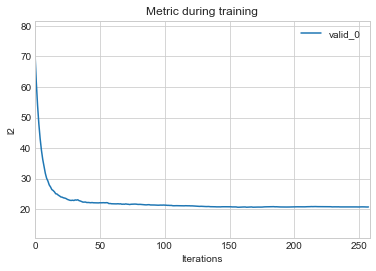

In [60]:
plot_metric(lgbmr);

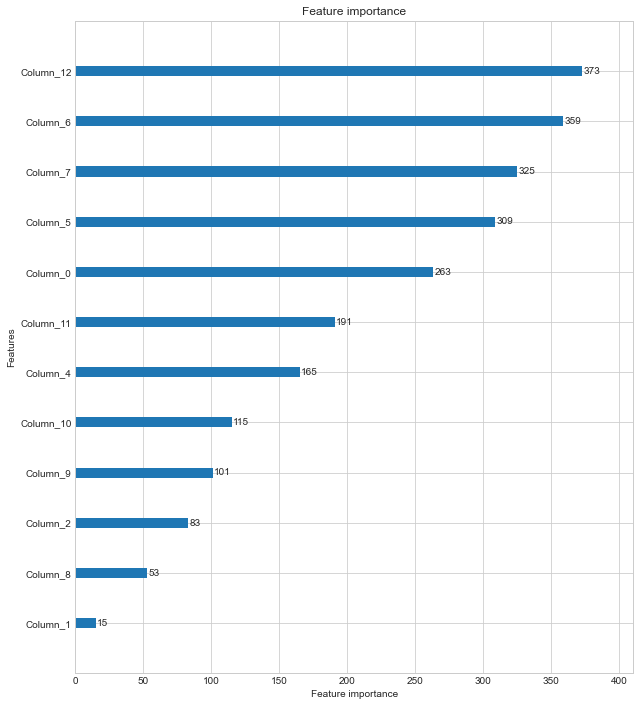

In [61]:
plot_importance(lgbmr, figsize=(10, 12));

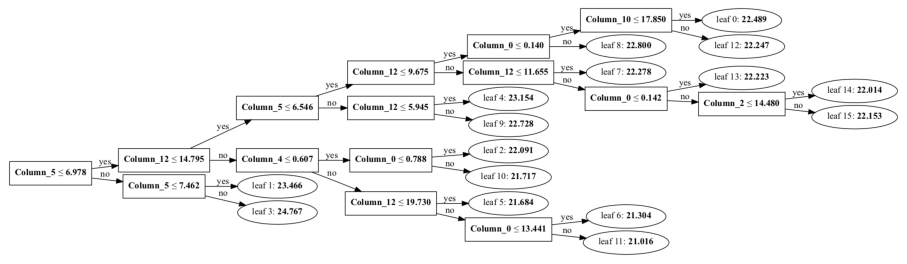

In [62]:
plot_tree(lgbmr, figsize=(16,10));

### 당뇨병 데이터

In [63]:
diabetes = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(
    diabetes.data, diabetes.target, test_size=0.2, random_state=123)

In [64]:
lgbmr = LGBMRegressor(n_estimators=400)
evals = [(X_test, y_test)]
lgbmr.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals,
          verbose=True)

preds = lgbmr.predict(X_test)

[1]	valid_0's l2: 5692.17
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 5218.79
[3]	valid_0's l2: 4835.34
[4]	valid_0's l2: 4479.84
[5]	valid_0's l2: 4183.42
[6]	valid_0's l2: 3924.35
[7]	valid_0's l2: 3726.96
[8]	valid_0's l2: 3555.3
[9]	valid_0's l2: 3407.95
[10]	valid_0's l2: 3291.33
[11]	valid_0's l2: 3201.78
[12]	valid_0's l2: 3114.69
[13]	valid_0's l2: 3059.18
[14]	valid_0's l2: 3005.79
[15]	valid_0's l2: 2945.18
[16]	valid_0's l2: 2876.37
[17]	valid_0's l2: 2822.71
[18]	valid_0's l2: 2791.31
[19]	valid_0's l2: 2786.39
[20]	valid_0's l2: 2745.25
[21]	valid_0's l2: 2724.07
[22]	valid_0's l2: 2705.17
[23]	valid_0's l2: 2685.41
[24]	valid_0's l2: 2663.2
[25]	valid_0's l2: 2659.75
[26]	valid_0's l2: 2636.48
[27]	valid_0's l2: 2615.15
[28]	valid_0's l2: 2640.63
[29]	valid_0's l2: 2624.73
[30]	valid_0's l2: 2615.14
[31]	valid_0's l2: 2601.41
[32]	valid_0's l2: 2593.79
[33]	valid_0's l2: 2555.64
[34]	valid_0's l2: 2572.12
[35]	valid_0's l2: 2581.22
[36]

In [65]:
cross_val = cross_validate(
    estimator=lgbmr,
    X=diabetes.data, y=diabetes.target,
    cv=5
)
print('avg fit time: {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg score time: {} (+/- {})'.format(cross_val['score_time'].mean(), cross_val['score_time'].std()))
print('avg test score: {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))


avg fit time: 0.21805806159973146 (+/- 0.037338239430256694)
avg score time: 0.0010396480560302735 (+/- 0.00012467541945686888)
avg test score: 0.30867643947179507 (+/- 0.07010708786960605)


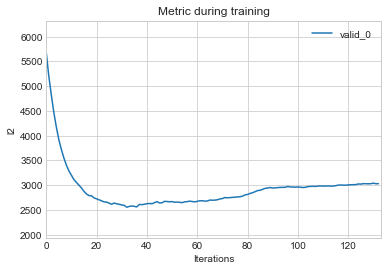

In [66]:
plot_metric(lgbmr);

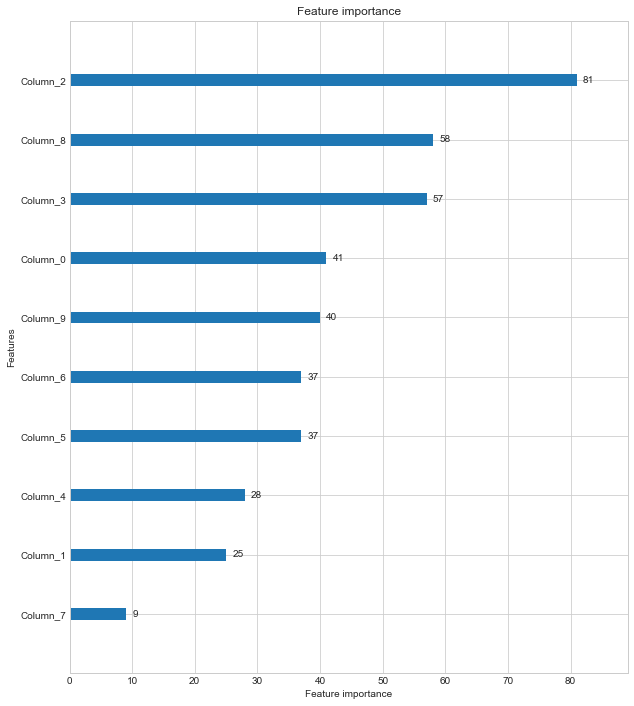

In [67]:
plot_importance(lgbmr, figsize=(10, 12));

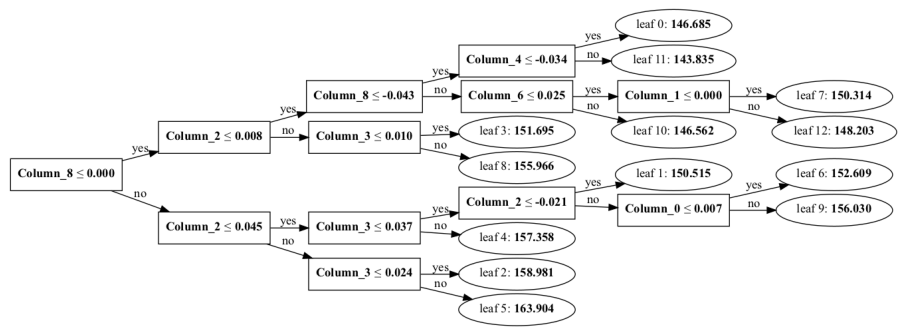

In [68]:
plot_tree(lgbmr, figsize=(16,10));